<a href="https://colab.research.google.com/github/juniorskg/fraud-detection/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Define business problem**

**task:** money laundering detection project

**Executive Summary:**
This projet aim to use SAML-D dataset to  make a machine learning model to detect whether a transaction is likely linked to money laundering.  three suitable machine learning model  were compared and the best one base on there recall value was selected.

# **Import Library**

In [ ]:
import pandas as pd
import sklearn.model_selection
from summarytools import dfSummary
import sklearn.compose
import sklearn.preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, recall_score,f1_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss
import numpy as np



# **Function definition**
here i define a function to visualise my model and some perfomance metric

In [ ]:
def performence(y_test,y_predicted , a):
  print(sklearn.metrics.classification_report(y_test, y_predicted))
  confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_predicted)

  if a==1:
    cm_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["not_laundering", "laundering"])

    cm_display.plot()

# **Data collection**

In [ ]:
df= pd.read_csv("SAML-D.csv")


# **Data Exploration**

the dataset contain 12 features  and 9 504 852 transaction . the target label is "Is_laundering"

**link to dataset:** https://www.kaggle.com/datasets/berkanoztas/synthetic-transaction-monitoring-dataset-aml

In [ ]:
df

,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type
0,10:35:19,2022-10-07,8724731955,2769355426,1459.15,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits
1,10:35:20,2022-10-07,1491989064,8401255335,6019.64,UK pounds,Dirham,UK,UAE,Cross-border,0,Normal_Fan_Out
2,10:35:20,2022-10-07,287305149,4404767002,14328.44,UK pounds,UK pounds,UK,UK,Cheque,0,Normal_Small_Fan_Out
3,10:35:21,2022-10-07,5376652437,9600420220,11895.00,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Fan_In
4,10:35:21,2022-10-07,9614186178,3803336972,115.25,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits
...,...,...,...,...,...,...,...,...,...,...,...,...
9504847,10:57:01,2023-08-23,2453933570,519744068,2247.25,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Small_Fan_Out
9504848,10:57:06,2023-08-23,9805510177,5416607878,927.18,UK pounds,UK pounds,UK,UK,Debit card,0,Normal_Small_Fan_Out
9504849,10:57:06,2023-08-23,7282330957,2995527149,1455.14,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Small_Fan_Out
9504850,10:57:11,2023-08-23,940337377,4812815165,25995.70,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Fan_In


split the data set into train and  test in random state 42 to have the same result at each execution

In [ ]:
df_train,df_test=sklearn.model_selection.train_test_split(df,random_state=42)

check null values

# **SUMMARIZE DATA INFOMATION**



1.   from the below graph we can observe that the 12 column of the dataset have no usefull information and have to be removed


2.    it also show the data type of each column in the dataset. by looking at that we observe that the  Time and the date  column are  not a suitable format.


3. at the "missing" column of the graph we observe that there is no missing values


4. at the seventh row  we can see that the dataset is highly imbalanced with 7 121 179 transaction (99.9%) which are not money laundering   and 7 460 transaction (0.1%) which are money laundering


5. it also show that there is no tansaction duplicate





In [ ]:
dfSummary(df_train)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Time[object],1. 15:22:422. 14:51:593. 14:17:254. 11:09:275. 12:58:546. 09:45:517. 10:09:288. 14:49:569. 17:26:2110. 11:42:4711. other,"158 (0.0%)155 (0.0%)154 (0.0%)153 (0.0%)153 (0.0%)152 (0.0%)152 (0.0%)152 (0.0%)152 (0.0%)152 (0.0%)7,127,106 (100.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADLklEQVR4nO3cwY3TYBRG0ecogmFja2QpJUAPKYItvdOFNzCswoIeriVzTgX/4kpPkfxleb1eA4Xb2Q/g/yE2MmIjIzYyYiMjNjJiIyM2MmIjIzYyt2VZvi3L8nb2Q7i+28x8nZnPZz+E63NGyYiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI3MbWZ+zsyfsx/C9S3+xYiKM0pGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyBi8kDF4IeOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEZGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKBmxkREbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYy1lVkrKvIOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKJllZr7MzKezH8L13fd9/76u6/vZD+H67uu6vj+fz9/btn2c/Riu6ziOt/vMzLZtH4/H49fZD+La/EAgIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjc5/59/nH2Q/h2o7jeFv2ff/h40kKPgsnY11Fxg8EMmIjIzYyYiMjNjJiIyM2MmIjIzYyfwFj50uCzHpkKgAAAABJRU5ErkJggg=="">",0(0.0%)
2,Date[object],1. 2023-02-092. 2023-02-013. 2023-02-064. 2023-02-225. 2022-12-236. 2023-04-037. 2023-02-208. 2023-02-159. 2023-05-0810. 2023-02-2411. other,"27,504 (0.4%)26,807 (0.4%)26,289 (0.4%)25,968 (0.4%)25,532 (0.4%)25,525 (0.4%)25,396 (0.4%)25,324 (0.4%)25,254 (0.4%)25,242 (0.4%)6,869,798 (96.4%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADfUlEQVR4nO3cMWobUQBF0S8jTNyMEAItRovwYrMI7UYITREbN0oRpwhRAgH7DijnVCHVFJfR5PNfVtfrdUDhYekH4P8hNjJiIyM2MmIjIzYyYiMjNjJiI7MaYzyNMcb1en1Z+Fm4c+vdbvc8xhir1eqr4PhMD9M0badp2o4xHpd+GO6bbzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiI7Oe5/n8/ue3RZ+Eu2eDQGblv8yi4s1GxrqKjHUVGUcfZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkDF7IuBZOxuCFjDcbGYMXMgYvZBx9kBEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRMXgh41o4GYMXMr7ZyPgZJWNdRca6ioxvNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MtZVZFwLJ2NdRcabjYzBCxmDFzKOPsiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyBi8kHEtnIzBCxlvNjIGL2QMXsg4+iAjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MtZVZGwQyFhXkfFmI2NdRca6ioyjDzJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MgYvZFwLJ2PwQsabjYzBCxmDFzKOPsiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyBi8kHEtnIzBCxnfbGT8jJKxriJjXUXGNxsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxnrKjKuhZOxriLjzUbG4IWMwQsZRx9kxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGQMXsi4Fk7G4IXMzzebK+F8pLdbv5Tr3W73/L5BgA8xz/P51oBqPU3T9nA4vGw2m9elHo77cblcvhyPx+3pdHocY/wa2xhjbDab1/1+/22Rp+MePd36S+dsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZNZj/LgWsvSDcB/+1tJ6nufz8Xjcjj9cC4F/9T6i+m1A5Vo4n+HmtXCDFzL+gUBGbGTERkZsZMRGRmxkxEZGbGTERuY7CLkQJ3942gEAAAAASUVORK5CYII="">",0(0.0%)
3,Sender_account[int64],Mean (sd) : 5006086280.3 (2885871826.5)min < med < max:28511.0 < 5000602806.0 < 9999986843.0IQR (CV) : 4991346263.0 (1.7),"285,132 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACX0lEQVR4nO3YvY8SURSG8XNhhcuHM+FD6Ggst5uEhsbO0j/W1s4CEmsKGysaQkIGCLhEGLHYNVbuMnPdhTc+vxYOnLk8QwjudDoZcO1Kl14AOMfNpRe4Vs65mplVCo7/OJ1Od/9yHwXPeWbPGmrg4mb33/g/C84WjsU5V+t0Oh+iKGoVmV+tVlvn3Ccz2xcYD7nm0PmLndlms0mdcx//9v5PhhoQm2+32+

# **Data Preprocessing**

1.   remove the missing data  

2.   remove column containing non usefull information ('Laundering_type')

3.   convert time , and date to the corect format by keeping only the hour for time and by spliting the date in to day, month and year



In [ ]:
df_train=df_train.drop('Laundering_type',axis=1)
df_test=df_test.drop('Laundering_type',axis=1)

In [ ]:
df_train['Time']= pd.to_datetime(df_train['Time'], format='%H:%M:%S').dt.hour
df_train['Year'] = pd.to_datetime(df_train['Date']).dt.year
df_train['Month'] = pd.to_datetime(df_train['Date']).dt.month
df_train['Day'] = pd.to_datetime(df_train['Date']).dt.day
df_train=df_train.drop('Date',axis=1)

In [ ]:
df_test['Time']= pd.to_datetime(df_test['Time'], format='%H:%M:%S').dt.hour
df_test['Year'] = pd.to_datetime(df_test['Date']).dt.year
df_test['Month'] = pd.to_datetime(df_test['Date']).dt.month
df_test['Day'] = pd.to_datetime(df_test['Date']).dt.day
df_test=df_test.drop('Date',axis=1)

# **Feature Engeneering**

1.  split the train and test dataframe into x_train for the feature label of the train dataframe, y_train for target label of the train dataframe, x_test for the feature label of the test dataframe and y_train into target label of the test dataframe


2. encoded the categorical data by using one hot encoder and scale the numerical data by using standard scaler


3. use random under sampler to handle the significant imbalance of the data sets. the reason why i used random sampler are:


*    the dataset contain a significantly  high amount of data point
*    the primary evaluation metric for our model is recall









In [ ]:
x_train=df_train.drop("Is_laundering",axis=1)
y_train= df_train["Is_laundering"]
x_test=df_test.drop("Is_laundering",axis=1)
y_test=df_test["Is_laundering"]

In [ ]:
X_train=x_train
X_test=x_test
categorical_data= x_train.select_dtypes(["object"]).columns
numerical_attribute= x_train.select_dtypes(["int64","int32","float64"]).columns
ct= sklearn.compose.ColumnTransformer([

          ("one-encoder",sklearn.preprocessing.OneHotEncoder(handle_unknown="ignore"),categorical_data),

           ("scaling",sklearn.preprocessing.StandardScaler(),numerical_attribute)
])
ct.fit(x_train)
x_train= ct.transform(x_train)
x_test= ct.transform(x_test)

In [ ]:
under_samp=RandomUnderSampler(sampling_strategy=1,random_state=42)
x_train,y_train=under_samp.fit_resample(x_train,y_train)
x_test,y_test=under_samp.fit_resample(x_test,y_test)

In [ ]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(14920, 76) (14920,) (4826, 76) (4826,)


# **GRID SEARCH**

 The machine learning model used for this project are  random forest, xgb classifier and logistic regression. each model hyperparameter is fine-turne using grid search base on  recall as the evaluation metric and then compare to one another . The best model is selected base on primarily recall and secondarily f1 score  

**evaluation metrics**


*   recall is used as primary evaluation metric as it is crucial to detect the laundering transaction
*   F1 score  is use a secondary evaluation metric because it will be detrimental to have too many non laundering transaction classified as laundering transaction.


# Random Forest
reason for choosen it:


1.   it is powerfull and flexible
2.   resistant to noise and outliers
3.   it can manage high dimensional dataset



In [ ]:
parameter_grid= {


  'max_depth': [None,10,20,30],
  'n_estimators': [10, 50, 100,200]

}

score = {
    "recall":"recall",
    "f1_score": make_scorer(f1_score)

}

rand_forest= GridSearchCV(estimator=RandomForestClassifier(),param_grid= parameter_grid,scoring=score,refit="recall", cv=5,n_jobs=-1)
rand_forest.fit(x_train,y_train)



GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'n_estimators': [10, 50, 100, 200]},
             refit='recall',
             scoring={'f1_score': make_scorer(f1_score, response_method='predict'),
                      'recall': 'recall'})

# XGB Classifier


1.   It is good in capturing complex relationships in the data
2.   The algorithms is good for handling imbalanced




In [ ]:
parameter_grid= {

    'learning_rate': [ 0.1, 0.2,0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'n_estimators': [100, 200,300],

}
score = {
    "recall":"recall",
    "f1_score": make_scorer(f1_score)

}
xgb_mod= GridSearchCV(XGBClassifier(),parameter_grid,scoring=score,refit="recall",cv=5,n_jobs=-1)
xgb_mod.fit(x_train,y_train)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 1.0]},
             refit='recall',
             scoring={'f1_score': make_scorer(f1_score, response_method='predict'),
                      'recall': 'recall'})

# Logistic Regression


1.    It’s simple and interpretable
2.    fast for new record classification

In [ ]:
parameter_grid= {

 "C":np.logspace(-3,3,7),
 "penalty":["l1","l2"]

}
score = {
    "recall":"recall",
    "f1_score": make_scorer(f1_score)

}
log_reg= GridSearchCV(LogisticRegression(),parameter_grid,scoring=score,refit="recall",cv=5,n_jobs=-1)
log_reg.fit(x_train,y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
35 fits failed out of a total of 70.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1194, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/us

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             refit='recall',
             scoring={'f1_score': make_scorer(f1_score, response_method='predict'),
                      'recall': 'recall'})

In [ ]:
print("recall of the best random forest Classifier is = {:.2f}".format(rand_forest.best_score_))
print("recall of the best random forest Classifier is: {}".format (rand_forest.best_params_))
print("f1 score of the best random forest clasifier is = {:.2f} :".format(rand_forest.cv_results_["mean_test_f1_score"][rand_forest.best_index_]))

print("")

print("recall of the best XGB Classifier is = {:.2f}".format(xgb_mod.best_score_))
print("best hyperparameter of XGB Classifier = {}".format (xgb_mod.best_params_))
print("f1 score of the best XGB Classifier is = {:.2f} :".format(xgb_mod.cv_results_["mean_test_f1_score"][xgb_mod.best_index_]))

print("")

print("recall of the best Logistic Regression Classifier is = {:.2f}".format(log_reg.best_score_))
print("best hyperparameter of Logistic Regression Classifier = {}".format (log_reg.best_params_))
print("f1 score of the best Logistic Regression clasifier is = {:.2f} :".format(log_reg.cv_results_["mean_test_f1_score"][log_reg.best_index_]))

recall of the best random forest Classifier is = 0.68
recall of the best random forest Classifier is: {'max_depth': None, 'n_estimators': 200}
f1 score of the best random forest clasifier is = 0.72 :

recall of the best XGB Classifier is = 0.73
best hyperparameter of XGB Classifier = {'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}
f1 score of the best XGB Classifier is = 0.74 :

recall of the best Logistic Regression Classifier is = 0.63
best hyperparameter of Logistic Regression Classifier = {'C': 0.1, 'penalty': 'l2'}
f1 score of the best Logistic Regression clasifier is = 0.70 :


# **Model Testing**

from the above information i selected XGB classifier as the best model and its best hyper parameter are {'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8} .

In this part of the project i will use the best model with is best hyperparameter to predict the target label on the test dataset .



TEST PERFOMANCE

              precision    recall  f1-score   support

           0       0.76      0.77      0.76      2413
           1       0.76      0.75      0.76      2413

    accuracy                           0.76      4826
   macro avg       0.76      0.76      0.76      4826
weighted avg       0.76      0.76      0.76      4826



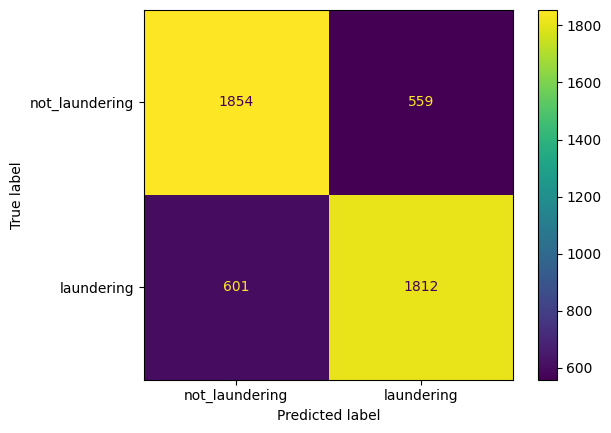

In [ ]:

y_predict= xgb_mod.best_estimator_.predict(x_test)


print("TEST PERFOMANCE\n")
performence(y_test,y_predict,1)

# **Evaluation**
Above the best model was tested on the test dataset and it gave a recall of 75% that is the model can succesfully detect 75% of money laundering transaction (1812 out of 2413) , it alsoo have a F1 score of 76% this show that it have a good balance between recall and precision that is the model also have a good prediction for non laundering transaction(1854 out of  2413).

in overall the model performance is decent as it can predict 75% of money laudering transactions and 77% of the non laundering transactions   but It some limitation  as it wrongly predict 559 transaction to be money laundering and 601 to not be money laundering .

# **Most Informative feature**

in this part we determine the most informative feature for our model.


1.   i collected the feature importances score for each encoded feature which were 76
2.   made a dataframe with there name and the importances value
3.   reduce them to the initial 12 features that i use by of each encoded feature
4. rank the features

**Result:**


1.   after doing we observe that the most important feature for our model is Received_currency which have a score of 0,042
2.   other relevant feature are Receiver_account,	Payment_type, Sender_account and  Payment_currency which all have a score of around 0,01





In [ ]:
 importances= xgb_mod.best_estimator_.feature_importances_

In [ ]:
feature_names = ct.get_feature_names_out(input_features=X_train.columns)



In [ ]:
feature_importance_df = pd.DataFrame({
    'Feature':  feature_names ,
    'Importance': importances
})

In [ ]:
#df_jun_age = df[df['name'].str.startswith('jun')]['age']
feat=[]
feat.append(feature_importance_df.loc[feature_importance_df['Feature']=='scaling__Time',"Importance"].values[0])
feat.append(feature_importance_df[feature_importance_df['Feature'].str.startswith("one-encoder__Payment_currency_")]["Importance"].mean())
feat.append(feature_importance_df[feature_importance_df['Feature'].str.startswith("one-encoder__Received_currency_")]["Importance"].mean())
feat.append(feature_importance_df[feature_importance_df['Feature'].str.startswith("one-encoder__Sender_bank_location_")]["Importance"].mean())
feat.append(feature_importance_df[feature_importance_df['Feature'].str.startswith("one-encoder__Receiver_bank_location_")]["Importance"].mean())
feat.append(feature_importance_df[feature_importance_df['Feature'].str.startswith("one-encoder__Payment_type_")]["Importance"].mean())



feat.append(feature_importance_df.loc[feature_importance_df['Feature']=='scaling__Sender_account',"Importance"].values[0])
feat.append(feature_importance_df.loc[feature_importance_df['Feature']=='scaling__Receiver_account',"Importance"].values[0])
feat.append(feature_importance_df.loc[feature_importance_df['Feature']=='scaling__Amount',"Importance"].values[0])
feat.append(feature_importance_df.loc[feature_importance_df['Feature']=='scaling__Year',"Importance"].values[0])
feat.append(feature_importance_df.loc[feature_importance_df['Feature']=='scaling__Month',"Importance"].values[0])
feat.append(feature_importance_df.loc[feature_importance_df['Feature']=='scaling__Day',"Importance"].values[0])


In [ ]:
feature_importance_df = pd.DataFrame({
    'Feature':  X_train.columns ,
    'Importance': feat
})
feature_importance_df.sort_values(by='Importance', ascending=False)


,Feature,Importance
5,Received_currency,0.042918
2,Receiver_account,0.013371
8,Payment_type,0.011664
1,Sender_account,0.010799
4,Payment_currency,0.010037
7,Receiver_bank_location,0.008582
6,Sender_bank_location,0.008129
3,Amount,0.008122
11,Day,0.008003
9,Year,0.007662
